In [3]:
import pyautogui as gui
import pywinauto as wind
import pytesseract
from time import sleep
import time
from pywinauto.application import Application
import path_location
import re
from PIL import ImageFilter
from IPython.display import display as disp_img_inline

pytesseract.pytesseract.tesseract_cmd = path_location.TESSERACT_LOC
RST_LOCATION = path_location.RST_LOCATION

if RST_LOCATION is None:
    print('Path to RST cannot be found')
    quit()

In [2]:
def click_here(x=None, y=None, pause=None, debug=False):
    gui.moveTo(x, y, pause=pause)
    if debug:
        gui.press('ctrl', presses=2, interval=.7)
    gui.click()

def get_app_prop(app):
    app_prop = app.rectangle()
    return (app_prop.left, app_prop.top, app_prop.width(), app_prop.height())

def get_app_prop2(app):
    app_prop = app.client_rect()
    return app_prop.width(), app_prop.height()

def get_sreenshot(app=None, wind_stat=None, screenname=None):
    if screenname is not None:
        screenname = 'screenshots/'+screenname
        if not screenname.endswith('.png'):
            screenname+='.png'
    else:
        screenname = str(time.time())+'.png'

    if app != None:
        app.set_focus()
        app_prop = get_app_prop(app)
        wind_stat = (app_prop[0], app_prop[1], app_prop[2], app_prop[3])
    elif wind_stat == None:
        print('[ERROR] Either app object or custom box has to be passed')
        return None
    return gui.screenshot(imageFilename=screenname, region=wind_stat)

def image_convert(image):
    greyscale = image.convert('L')
    blackwhite = greyscale.point(lambda x: 0 if x < 200 else 255, '1')
    return image
    # return blackwhite

In [1]:
def app_get_region(app, x, y, width=10, height=10, use_ratio=False, draw_outline=True):
    # PCARS 2 options change based on windows size (resolution)
    if use_ratio:
        app_h = app.client_rect().height()
        app_w = app.client_rect().width()
        x = x * app_w/1768
        y = y * app_h/992
        width = width * app_w/1768
        height = height * app_h/992
    x,y,width,height = int(x),int(y),int(width),int(height)
    x, y = app.client_to_screen((x,y))
    
    if draw_outline:
        class cusrect:
            left=x
            top=y
            right=left+width
            bottom=top+height

        for _ in range(25):
            app.draw_outline(rect=cusrect)
    # gui.moveTo(x, y)
    return x, y, width, height

In [6]:
def ocr(img, v1=False, raw=False):
    if v1:
        return pytesseract.image_to_string(img).split('\n')
    else:
        import io
        import json
        import cv2
        import numpy as np
        import requests

        img.save("screenshot.jpg")
        img = cv2.imread("screenshot.jpg")
        url_api = "https://api.ocr.space/parse/image"
        _, compressedimage = cv2.imencode(".jpg", img, [1, 90])
        file_bytes = io.BytesIO(compressedimage)

        result = requests.post(url_api,
                    files = {"screenshot.jpg": file_bytes},
                    data = {"apikey": path_location.OCR_SPACE_API_KEY,
                            "language": "eng",'isOverlayRequired':raw})
        result = result.content.decode()
        result = json.loads(result)
        if raw:
            return result
        parsed_results = result.get("ParsedResults")[0]
        return parsed_results.get("ParsedText").split()

In [4]:
try:
    pc2 = Application().connect(title_re='.*Project CARS 2.*')['Project Cars 2']
except wind.findwindows.ElementNotFoundError:
    print('[ERROR] Launch PCARS 2 first')
    
try:
    rst = Application().connect(title_re='MainWindow').MainWindow
except wind.findwindows.ElementNotFoundError:
    rst = Application().start(RST_LOCATION+'\\RST Software.exe').MainWindow
except wind.findwindows.ElementAmbiguousError:
    print('[ERROR] Sad, but for now, close the params child window.')

try:
    pc2
    rst
except NameError:
    print('[ERROR] An aplication failed to run')
    quit()

D:\Users\GV\Anaconda3\lib\site-packages\pywinauto\application.py:1087: UserWarning: 32-bit application should be automated using 32-bit Python (you use 64-bit Python)
  UserWarning)


## RST

In [5]:
def open_rst_params():
    rst.set_focus()
    RST_FILE_OFFSET_X = 350
    RST_FILE_OFFSET_Y = 10
    RST_NEXT_OFFSET_X = RST_FILE_OFFSET_X+10
    RST_NEXT_OFFSET_Y = RST_FILE_OFFSET_Y+75

    #Select file
    x, y, width, height = app_get_region(rst, RST_FILE_OFFSET_X, RST_FILE_OFFSET_Y, 60, 40, draw_outline=True)
    click_here(x=x+width/2, y=y+height/2, pause=0.5)
    
    #Select next car parameters
    x, y, width, height = app_get_region(rst, RST_NEXT_OFFSET_X, RST_NEXT_OFFSET_Y, 280, 30, draw_outline=True)
    click_here(x=x+width/2, y=y+height/2, pause=0.5)




def open_rst_settings(settings):
    def find_rst_settings(pos):
        setup_bar_width = get_app_prop2(rst)[0]
        mid_op = setup_bar_width/4
        return (int(mid_op*pos), int(setup_bar_width/4))
        
    settings_type = {'suspension':1, 'dampers':2, 'gearing':3}
    rst.set_focus()
    x, width = find_rst_settings(settings_type[settings])
    x, y, width, height = app_get_region(rst, x, 70, width, 40, draw_outline=True)
    click_here(x+width/2, y+height/2, pause=.5, debug=True)

open_rst_params()

## PCARS2

In [7]:
def get_stats_gear_pc2():
    # Select ECU menu
    rst.set_focus()
    pc2.set_focus()
    pos = app_get_region(pc2, x=int(get_app_prop2(pc2)[0]/2)+250, y=250, use_ratio=True)
    click_here(pos[0], pos[1])

    x, y, width, height = app_get_region(pc2, x=949, y=520,  width=70, height=210, use_ratio=True)
    content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='Gear.png'))
    return ocr(content)

def set_stats_gear_rst(gears):
    rst.set_focus()
    rst_pos_x, rst_pos_y = rst.rectangle().left, rst.rectangle().top
    rst_pos_height, rst_pos_width = rst.rectangle().height(), rst.rectangle().width()
    rst_width_mid = rst_pos_x+rst_pos_width/2
    rst_y_firstfield = rst_pos_y+180
    for gear, val in enumerate(gears):
        gui.click((rst_width_mid, rst_y_firstfield+55*gear))
        try:
            float(val)
            gui.typewrite(val)
        except ValueError:
            print(f'[ERROR] Gear {gear} ({val}) not a number')
            gui.typewrite('0')

gears = get_stats_gear_pc2()
open_rst_settings('gearing')
set_stats_gear_rst(gears)

In [8]:
def retriev_ocr(content, debug=True):
    img=content
    results = ocr(content)
    content = []
    if len(results) == 0:
        content.append('1')
    else:
        for val in results:
            try:
                content.append(re.match('\\d+', val).group())
            except:
                content.append('0')
    if debug:
        disp_img_inline(img)
        print(f'{results}\t->\t{content}')
        print()
    return content


In [9]:
def get_stats_sus_pc2():
    # Select suspension menu
    pc2.set_focus()
    pos = app_get_region(pc2, x=int(get_app_prop2(pc2)[0]/2)-200, y=250, use_ratio=True)
    click_here(pos[0], pos[1])

    # Get front spring
    x, y, width, height = app_get_region(pc2, x=600, y=497,  width=90, height=23, use_ratio=True)
    content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='sus_front_spring'))
    f_spring = retriev_ocr(content)[0]

    # Get rear spring
    x, y, width, height = app_get_region(pc2, x=600, y=737,  width=90, height=23, use_ratio=True)
    content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='sus_rear_spring.png'))
    r_spring = retriev_ocr(content)[0]
    
    # Get front antirollbar
    x, y, width, height = app_get_region(pc2, 935, y=470,  width=90, height=26, use_ratio=True)
    content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='sus_front_arb.png'))
    f_ar = retriev_ocr(content)[0]
    
    # Get rear antirollbar
    x, y, width, height = app_get_region(pc2, 935, y=710,  width=90, height=26, use_ratio=True)
    content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='sus_rear_arb.png'))
    r_ar = retriev_ocr(content)[0]
    
    return f_spring, r_spring, f_ar, r_ar

def set_stats_sus_rst(stats):
    rst.set_focus()
    
    prop= get_app_prop2(rst)
    seperator = prop[0]/3
    start = seperator/2

    pos = app_get_region(rst, x=start, y=230)
    gui.click(pos[0], pos[1])
    gui.typewrite(stats[0])

    pos = app_get_region(rst, x=start+seperator, y=230)
    gui.click(pos[0], pos[1])
    gui.typewrite(stats[2])

    pos = app_get_region(rst, x=start, y=435)
    gui.click(pos[0], pos[1])
    gui.typewrite(stats[1])

    pos = app_get_region(rst, x=start+seperator, y=435)
    gui.click(pos[0], pos[1])
    gui.typewrite(stats[3])

In [10]:
stats = get_stats_sus_pc2()
open_rst_settings('suspension')
set_stats_sus_rst(stats)

['158N', 'Imm']	->	['158', '0']



['16bNjmm']	->	['16']



['130', 'N/mm']	->	['130', '0']



[]	->	['0']



def image_convert(image, apply_correcttion = False, ifilter=None):
    greyscale = image.convert('L')
    blackwhite = greyscale.point(lambda x: 0 if x < 200 else 255, '1')
    if ifilter is not None:
        if ifilter not in [ImageFilter.SHARPEN,ImageFilter.DETAIL,ImageFilter.EDGE_ENHANCE,ImageFilter.EDGE_ENHANCE_MORE]:
            ifilter = ImageFilter.EDGE_ENHANCE_MORE
        blackwhite = blackwhite.filter(ifilter)
    return blackwhite if apply_correcttion else image

# Select dampers menu
rst.set_focus()
pc2.set_focus()

# Get front damp
x, y, width, height = app_get_region(pc2, x=595, y=415,  width=95, height=183, use_ratio=True)
content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='sus_front_damp'), apply_correcttion=1)
f_damp = retriev_ocr(content)
content

from PIL import Image
for ifilter_type in [ImageFilter.SHARPEN,ImageFilter.DETAIL,ImageFilter.EDGE_ENHANCE,ImageFilter.EDGE_ENHANCE_MORE]:
    content =  image_convert(Image.open('screenshots/sus_front_damp.png'), ifilter=ifilter_type)
    f_damp = retriev_ocr(content)
    content.show()

In [72]:
def get_stats_damp_pc2():
    # Select dampers menu
    pc2.set_focus()
    pc2.set_focus()
    pos = app_get_region(pc2, x=int(get_app_prop2(pc2)[0]/2), y=250, use_ratio=True)
    gui.click(pos[0], pos[1])

    # Get front damp
    x, y, width, height = app_get_region(pc2, x=595, y=445,  width=95, height=105, use_ratio=True)
    content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='sus_front_damp'))
    f_damp = retriev_ocr(content)

    # Get rear damp
    x, y, width, height = app_get_region(pc2, x=595, y=710,  width=95, height=105, use_ratio=True)
    content = image_convert(get_sreenshot(wind_stat=(x, y, width, height), screenname='sus_rear_damp'))
    r_damp = retriev_ocr(content)
    
    return f_damp, r_damp

def set_stats_sus_rst(stats):
    print(stats)
    rst.set_focus()
    
    prop= get_app_prop2(rst)
    x_seperator_width = int(prop[0]/3)
    x_start = int(x_seperator_width/2)

    y_seperator_width = 50
    y_start_front = 230
    y_start_rear = 485

    front_damp = stats[0]
    rear_damp = stats[1]

    if len(front_damp) < 4:
        front_damp.extend(['1']*(4-len(front_damp)))

    if len(rear_damp) < 4:
        rear_damp.extend(['1']*(4-len(rear_damp)))

    for pos, stat in enumerate(front_damp):
        gui_pos = app_get_region(rst, x=x_start, y=pos*y_seperator_width+y_start_front)
        gui.click(gui_pos[0], gui_pos[1])
        gui.typewrite(stat)

    for pos, stat in enumerate(rear_damp):
        gui_pos = app_get_region(rst, x=x_start, y=pos*y_seperator_width+y_start_rear)
        gui.click(gui_pos[0], gui_pos[1])
        gui.typewrite(stat)

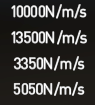

['1000mq/m/s', '1350m', '/m/s', '5050N/m/s']	->	['1000', '1350', '0', '5050']



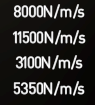

['8000N/m/s', '11500N/m/s', '3100N/m/s', '535(N/m/s']	->	['8000', '11500', '3100', '535']

(['1000', '1350', '0', '5050'], ['8000', '11500', '3100', '535'])


In [73]:
stats = get_stats_damp_pc2()
open_rst_settings('dampers')
set_stats_sus_rst(stats)